# Finalized Data Preprocessing and Model Creation

In [3]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.1 MB/s eta 0:00:00


## Data Preprocessing

In [4]:
# All the imports that are needed for the models
import keras
import keras_tuner
import sklearn
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from keras.layers import Dense
from keras.models import Sequential
from scikeras.wrappers import KerasRegressor
from keras.optimizers import SGD
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ARDRegression, LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures

In [5]:
# This is our index of different timezone and major cities within each timezone in the form of a dictionary
cities_by_timezone = {
    'Pacific Time': ['Los Angeles', 'San Francisco Bay Area', 'Seattle', 'Portland', 'San Luis Obispo', 'Sacramento', 'San Diego', 'Santa Barbara', 'Camarillo', 'Fremont', 'Bend', 'Reno', 'Spokane', 'Las Vegas', 'Fresno'],
    'Mountain Time': ['Denver', 'Boulder', 'Salt Lake City', 'Missoula', 'Santa Fe', 'Phoenix', 'Lehi', 'Logan', 'Boise'],
    'Central Time': ['Austin', 'Chicago', 'Minneapolis', 'Milwaukee', 'Nashville', 'Dallas', 'Cincinnati', 'Columbus', 'Indianapolis', 'Nebraska City', 'Kansas City'],
    'Eastern Time': ['New York City', 'Boston', 'Atlanta', 'Ann Arbor', 'Miami', 'Detroit', 'Stamford', 'Washington DC', 'Philadelphia', 'Raleigh', 'Walnut', 'Madison', 'Dover', 'Burlington', 'Wilmington', 'Nashua', 'Baltimore', 'Tampa Bay']
}

def get_timezone(city):
    '''
    Retrieve the timezone associated with a city.

    @type city: string
    @param city: name of city to retrieve timezone for
    @rtype: string, None
    @returns timezone: timezone of a city if in an index; otherwise, None
    '''
    for timezone, cities in cities_by_timezone.items():
        if city in cities:
            return timezone
    return None

[*********************100%***********************]  1 of 1 completed


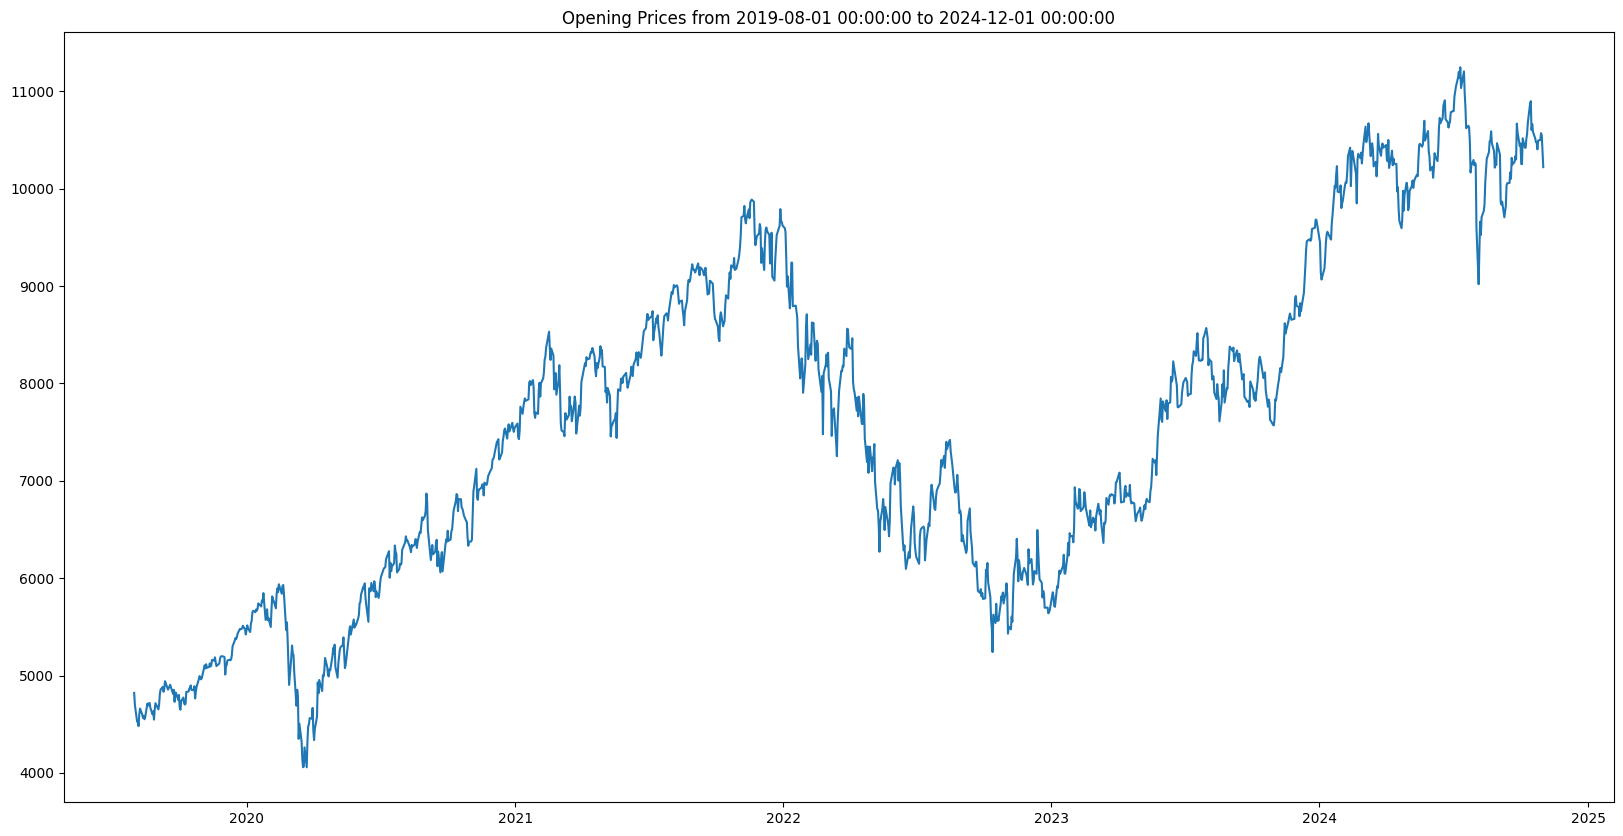

Price                         Adj Close         Close          High  \
Date                                                                  
2019-08-01 00:00:00+00:00   4762.810059   4762.810059   4924.919922   
2019-08-02 00:00:00+00:00   4655.560059   4655.560059   4712.990234   
2019-08-05 00:00:00+00:00   4469.970215   4469.970215   4534.649902   
2019-08-06 00:00:00+00:00   4531.810059   4531.810059   4562.890137   
2019-08-07 00:00:00+00:00   4550.560059   4550.560059   4563.459961   
...                                 ...           ...           ...   
2024-10-28 00:00:00+00:00  10523.860352  10523.860352  10582.809570   
2024-10-29 00:00:00+00:00  10745.330078  10745.330078  10776.650391   
2024-10-30 00:00:00+00:00  10468.049805  10468.049805  10621.509766   
2024-10-31 00:00:00+00:00  10154.190430  10154.190430  10393.200195   
2024-11-01 00:00:00+00:00  10281.370117  10281.370117  10338.169922   

Price                               Low          Open  Volume  price_diff  


In [6]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Download NASDAQ 100 data
stock_data = yf.download('^NDXT', start=datetime(2019, 8, 1), end=datetime(2024, 12, 1))
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.get_level_values(0)

def closest_day(row, df):
    target_date = row.name - timedelta(days=90)
    available_dates = df.index
    closest_date = available_dates[available_dates <= target_date].max()
    # if target_date != closest_date:
    #     print(f"target date is: {target_date}")
    #     print(f"closest date: {closest_date}")
    return closest_date

# Calculate 7-day difference in the Open price
stock_data['price_diff'] = stock_data.apply(
    lambda row: row['Open'] - stock_data.loc[closest_day(row, stock_data), 'Open'] if pd.notnull(closest_day(row, stock_data)) else None,
    axis=1
)

stock_data.to_csv('stock_data.csv', index = False, encoding='utf-8')

# Visualize our preliminary stock data of opening prices
plt.figure(figsize = (20,10))
plt.title('Opening Prices from {} to {}'.format(datetime(2019, 8, 1),
                                                datetime(2024, 12, 1)))
plt.plot(stock_data['Open'])
plt.show()

print(stock_data)

In [7]:
layoff_data = pd.read_csv('tech_layoffs.csv')
print(layoff_data.dtypes)
print(layoff_data.head())

#                                int64
Company                         object
Location_HQ                     object
Region                          object
State                           object
Country                         object
Continent                       object
Laid_Off                       float64
Date_layoffs                    object
Percentage                      object
Company_Size_before_Layoffs     object
Company_Size_after_layoffs      object
Industry                        object
Stage                           object
Money_Raised_in__mil           float64
Year                             int64
latitude                       float64
longitude                      float64
dtype: object
   #        Company    Location_HQ                  Region       State  \
0  1  Tamara Mellon    Los Angeles                     NaN  California   
1  2   HopSkipDrive    Los Angeles                     NaN  California   
2  3    Panda Squad  San Francisco  San Francisco Bay Area  Ca

In [8]:
import pandas as pd

# Ensure Date_layoffs is in datetime format and remove any timezone information
layoff_data['Date_layoffs'] = pd.to_datetime(layoff_data['Date_layoffs']).dt.tz_localize(None)

# Remove timezone info from stock_data index (if it has timezones)
stock_data.index = stock_data.index.tz_localize(None)

# Function to find the closest available date in stock_data for a given target_date
def find_closest_date(df, target_date):
    available_dates = df.index
    closest_date = available_dates[available_dates <= target_date].max()
    return closest_date

# Function to assign the 90-day price difference (from the stock_data's price_diff column)
def get_stock_delta(layoff_date):
    # Find the closest available date for the layoff date in stock_data
    closest_date = find_closest_date(stock_data, layoff_date)

    # If the closest date is found, return the pre-calculated 'price_diff'
    if pd.notnull(closest_date):
        return stock_data.loc[closest_date, 'price_diff']
    else:
        return None

# Apply the function to assign stock_delta using the pre-calculated 'price_diff' column
layoff_data['stock_delta'] = layoff_data['Date_layoffs'].apply(get_stock_delta)
layoff_data.sort_values(by='Date_layoffs', inplace=True)

# Display the updated DataFrame
layoff_data[['Date_layoffs', 'stock_delta']]


,Date_layoffs,stock_delta
0,2020-03-12,-950.669922
1,2020-03-13,-795.139648
2,2020-03-13,-795.139648
3,2020-03-16,-1064.330078
4,2020-03-16,-1064.330078
...,...,...
1835,2024-06-26,242.679688
1833,2024-06-26,242.679688
1836,2024-06-26,242.679688
1837,2024-06-27,270.879883


In [9]:
layoff_data['Company'] = layoff_data['Company'].replace({'SaleSan Franciscoorce': 'Salesforce'})

layoff_data['Company_Size_before_Layoffs'] = pd.to_numeric(
    layoff_data['Company_Size_before_Layoffs'].str.replace(',', ''), errors='coerce'
)
layoff_data = layoff_data.sort_index()
layoff_data = layoff_data[(layoff_data['Continent'] == 'North America') &
                          (layoff_data['Country'] == 'USA') &
                          (layoff_data['Company_Size_before_Layoffs'] >= 10)].drop(columns=["Company", "latitude", "longitude", "Continent", "Country", "#"])

# Assign new attribute 'Timezone' based on city
layoff_data['Region'] = layoff_data['Location_HQ'].map(get_timezone)
layoff_data = layoff_data.drop(columns=["Location_HQ", "Company_Size_after_layoffs", "Laid_Off","State"])

#Incorporate stock price
layoff_data = layoff_data.reset_index()


industry_encoder = LabelEncoder()
layoff_data['industry_encoded'] = industry_encoder.fit_transform(layoff_data['Industry'])

time_encoder = LabelEncoder()
layoff_data['Region_encoded'] = time_encoder.fit_transform(layoff_data['Region'])

# Create LabelEncoder instance for stage column
stage_encoder = LabelEncoder()
layoff_data['stage_encoded'] = stage_encoder.fit_transform(layoff_data['Stage'])
layoff_data = layoff_data.drop(columns=["Industry", "Stage","Year","Region"])
layoff_data['Money_Raised_in__mil'] = layoff_data['Money_Raised_in__mil'] * 1000000

#convert date layoffs to unix
layoff_data['Date_layoffs'] = layoff_data['Date_layoffs'].apply(lambda x: int(datetime.timestamp(x)))

# Set our target to be the percentage of a company expected to be laid off at a specific point in time
Y = layoff_data['Percentage'].str.replace(",",".").astype(float)
# Extract and encode our string data such that it makes our data preprocessing more organized
industry = layoff_data['industry_encoded'].values.reshape(-1, 1)
stage = layoff_data['stage_encoded'] .values.reshape(-1, 1)
region = layoff_data['Region_encoded'].values.reshape(-1, 1)

# One-hot encode the string data columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
industry_onehot, stage_onehot, region_onehot = encoder.fit_transform(industry), encoder.fit_transform(stage), encoder.fit_transform(region)

# Drop the original categorical columns from layoff_data
layoff_data = layoff_data.drop(columns=["industry_encoded", "stage_encoded", "Region_encoded", "Percentage"])

display(layoff_data)

print(layoff_data.isnull().sum())


,index,Date_layoffs,Company_Size_before_Layoffs,Money_Raised_in__mil,stock_delta
0,0,1583971200,50.0,90000000.0,-950.669922
1,1,1584057600,80.0,45000000.0,-795.139648
2,3,1584316800,16.0,6000000.0,-1064.330078
3,4,1584316800,591.0,79000000.0,-1064.330078
4,5,1584489600,20.0,4000000.0,-1340.020020
...,...,...,...,...,...
998,1829,1719187200,1000.0,509000000.0,257.769531
999,1830,1719187200,1143.0,100000000.0,257.769531
1000,1836,1719360000,1059.0,574000000.0,242.679688
1001,1837,1719446400,500.0,105000000.0,270.879883


index                           0
Date_layoffs                    0
Company_Size_before_Layoffs     0
Money_Raised_in__mil           39
stock_delta                     0
dtype: int64


In [10]:
layoff_data["Money_Raised_in__mil"].fillna(layoff_data["Money_Raised_in__mil"].mean(), inplace=True)

<ipython-input-10-c85c003c7c05>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  layoff_data["Money_Raised_in__mil"].fillna(layoff_data["Money_Raised_in__mil"].mean(), inplace=True)


In [11]:


layoff_data_df = pd.DataFrame(layoff_data)

# Convert one-hot encoded arrays into DataFrames with appropriate column names
industry_onehot_df = pd.DataFrame(industry_onehot, columns=[f'industry_{i}' for i in range(industry_onehot.shape[1])])
stage_onehot_df = pd.DataFrame(stage_onehot, columns=[f'stage_{i}' for i in range(stage_onehot.shape[1])])
region_onehot_df = pd.DataFrame(region_onehot, columns=[f'region_{i}' for i in range(region_onehot.shape[1])])

# Convert Y (Percentage) to a DataFrame
Y_df = pd.DataFrame(Y, columns=["Percentage"])

# Concatenate all data into a single DataFrame
combined_data = pd.concat([layoff_data_df.reset_index(drop=True), industry_onehot_df, stage_onehot_df, region_onehot_df, Y_df], axis=1)

# Save to CSV
combined_data.to_csv("layoff_data_with_onehot.csv", index=False, encoding='utf-8')

print("Data saved to layoff_data_with_onehot.csv")


Data saved to layoff_data_with_onehot.csv


In [12]:

# Concatenate numerical features and one-hot encoded features, and set it as X
X = np.hstack((layoff_data.values, industry_onehot, stage_onehot, region_onehot))

In [13]:
# layoff_data.values, industry_onehot, stage_onehot, region_onehot
print("LAYOFF DATA VALS:", str(layoff_data.values[0]))
print("INDUSTRY ONEHOT:", str(industry_onehot[0]))
print("STAGE ONEHOT:", str(stage_onehot[0]))
print("REGION ONEHOT:", str(region_onehot[0]))

print("X:", str(X[0]))

LAYOFF DATA VALS: [ 0.00000000e+00  1.58397120e+09  5.00000000e+01  9.00000000e+07
 -9.50669922e+02]
INDUSTRY ONEHOT: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
STAGE ONEHOT: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
REGION ONEHOT: [0. 0. 1. 0.]
X: [ 0.00000000e+00  1.58397120e+09  5.00000000e+01  9.00000000e+07
 -9.50669922e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [14]:
# Let's take a look at the shape of our features and our target
X.shape, Y.shape

((1003, 61), (1003,))

In [15]:
# Assuming X and Y are already sorted by date (chronologically)

# Define the split ratio (e.g., 80% for training, 20% for testing)
train_size = int(0.8 * len(X))  # 80% of the data for training

# Chronologically split the data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# Print the shapes of the resulting sets
print("Training set shapes: X_train =", X_train.shape, ", Y_train =", y_train.shape)
print("Testing set shapes: X_test =", X_test.shape, ", Y_test =", y_test.shape)


Training set shapes: X_train = (802, 61) , Y_train = (802,)
Testing set shapes: X_test = (201, 61) , Y_test = (201,)


In [16]:
# Finally, let's take a look at our target!
Y

,Percentage
0,40.0
1,10.0
2,100.0
3,22.0
4,20.0
...,...
998,3.0
999,35.0
1000,17.0
1001,4.0


# Model 1: Basic Regression Models

For our first model, we want to determine whether or not our prediction model performs well with basic regression models. If it does, then it is a matter of choosing the correct regression model to analyze the data! If not, this means that we may need to look into more complex models, such as neural networks or decision trees.

In [17]:
mse_arr = []
linreg = LinearRegression()

X_train_df, y_train_df = pd.DataFrame(np.array(X_train)), pd.DataFrame(np.array(y_train))

linreg.fit(X_train_df, y_train_df)
yhat_train, yhat_test = linreg.predict(X_train), linreg.predict(X_test)

MSE_train, MSE_test = np.mean((y_train.values - yhat_train)**2), np.mean((y_test.values - yhat_test)**2)
mse_arr.append((MSE_train, MSE_test))
print(f"MSE_train: {MSE_train}\nMSE_test: {MSE_test}")

MSE_train: 464.5621495144079
MSE_test: 651.3433381307756


As we can see, while our Linear Regression model is not awful, it can certainly be a whole lot better. Looking into another form of regression models, Polynomial Regression, we can see how our error change as we add more degrees to our polynomial model

In [18]:
for k in range(2,4):
    # Create kth degree polynomial
    polyreg = PolynomialFeatures(k)

    # Transform features to fit polynomial model
    train_features = polyreg.fit_transform(X_train_df)
    test_features = polyreg.fit_transform(X_test)

    # Create polynomial regression
    polyreg = LinearRegression()
    polyreg.fit(train_features, y_train_df)

    # Get training and testing predictions
    yhat_train = polyreg.predict(train_features)
    yhat_test = polyreg.predict(test_features)

    # Display training and testing MSEs
    MSE_train = np.mean((y_train.values - yhat_train) ** 2)
    MSE_test = np.mean((y_test.values - yhat_test) ** 2)

    mse_arr.append((MSE_train, MSE_test))
    print(f'Degree: {k}\n    MSE_train: {MSE_train}\n    MSE_test: {MSE_test}')

Degree: 2
    MSE_train: 513.8418175281098
    MSE_test: 2595.4919428224102
Degree: 3
    MSE_train: 489.00602714310776
    MSE_test: 1210.6010928457056


If we graph our data, we can then see how jagged our error measures are for our training and testing data, and how our model may be underfitting due to the difference in complexity between the model and our data.

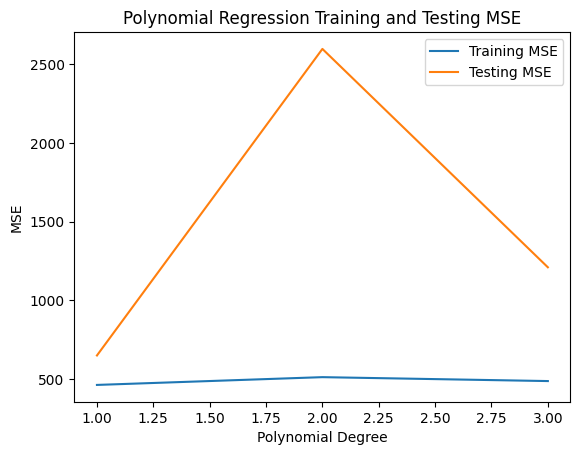

In [19]:
mse_train = [pair[0] for pair in mse_arr]
mse_test = [pair[1] for pair in mse_arr]

# Plot a graph of the training and testing MSE of the model over time
degrees = range(1, len(mse_arr) + 1)
plt.plot(degrees, mse_train, label='Training MSE')
plt.plot(degrees, mse_test, label='Testing MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Polynomial Regression Training and Testing MSE')
plt.legend()
plt.show()

Finally, we can look at a special regression model called Automatic Relevance Determination Regression. The main premise of this method is that it, similar to Linear Regression, fits a line to the data and determines feature relevance by shrinking irrelevant features.

In [20]:
ard = ARDRegression().fit(X_train, y_train_df)
yhat_train, yhat_test = ard.predict(X_train), ard.predict(X_test)

MSE_train, MSE_test = np.mean((y_train.values - yhat_train)**2), np.mean((y_test.values - yhat_test)**2)

print(f'Training Mean Squared Error: {MSE_train}\nTesting Mean Squared Error: {MSE_test}')

Training Mean Squared Error: 374.11491016846907
Testing Mean Squared Error: 554.8460415566956


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Model 1: Analysis/Conclusion

From these models, it can be seen that while they are able to fit the data to some degree, they simply do not fit the data well enough to call it a day. Each of these models have their shortcomings when it comes to predicting training or testing data, or even both.

Thus, it would make sense that we would need a model that either illustrates the level of complexity of the model effectively or is specialized in analyzing time series data. For that, we turn to our next two models: a Neural Network and a RandomForestRegressor.

# Model 2: Neural Network

Next, we will be looking at the neural network architecture and if it may perform effectively in predicting the layoff percentages of companies. We will first try to evaluate the data with a manually created ANN, then move on towards an ANN in which the hyperparameters are modified according to the data to minimize the loss.

In [21]:
def build_nn():
    '''
    Build an Artificial Neural Network model composed of an input layer of 12 nodes with input_dim=51, an output layer of 1
    node, and 3 hidden layers of 12 nodes each, with each layer having a sigmoid activation function applied to it.

    Additionally, compile the model, setting the optimizer to be SGD with an LR of 0.1, measuring the loss with MSE and calculating
    the MSE metric.

    @type model: keras_Sequential() object
    @returns model: a built and compiled Artificial Neural Network model with the given configuration
    '''
    model = Sequential([
        Dense(12, activation='sigmoid', input_dim=61),
        Dense(12, activation='sigmoid'),
        Dense(12, activation='sigmoid'),
        Dense(12, activation='sigmoid'),
        Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer=SGD(learning_rate=0.1), loss='mse', metrics=['mse'])
    return model

def buildHPmodel(hp):
  '''
  Setup a hyperparameter model that enables us to choose the best to predict our target percentage of employees laid off at a company.

  @type hp: keras_tuner_HyperParameters object
  @param hp: the HyperParameters object that enables us to change our model's hyperparameters

  @type model: keras_Sequential() object
  @returns model: a fully configured Hyperparameter model that enables a user to modify an ANN's hyperparameters to their data
  '''
  model= Sequential([
      Dense(12, activation = 'sigmoid', input_dim = 61),
      Dense(units=hp.Int("units1", min_value=3, max_value=24, step=5),activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
      Dense(units=hp.Int("units1", min_value=3, max_value=24, step=5),activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
      Dense(units=hp.Int("units1", min_value=3, max_value=24, step=5),activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
      Dense(units=1,activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
])
  learning_rate = hp.Float("lr", min_value=0.05, max_value=0.3, sampling="log")
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
  return model

# This is a tuner that we will be using to perform hyperparameter tuning on the second NN model that we use!
tuner = keras_tuner.GridSearch(
    hypermodel=buildHPmodel,
    objective="val_loss",
    directory="tunerStore",
    project_name="tunerInstance5",
    max_trials=50,
    seed=12,
    executions_per_trial=1,
    tune_new_entries=True,
    allow_new_entries=True,
    max_consecutive_failed_trials=3
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now that we have our ANN and tuner definitions set, we can perform a similar process to that of Model 1 in where we will fit the training data to the model, and see its error:

In [22]:
# Let us try out our first neural network to see how well in performs in our predictive task!
nn_regressor = KerasRegressor(model=build_nn, epochs=100, batch_size=5, verbose=0)
hist = nn_regressor.fit(X_train, y_train)
predictions_train, predictions_test = nn_regressor.predict(X_train), nn_regressor.predict(X_test)

print('Training Mean Squared Error:', mean_squared_error(predictions_train, y_train))
print('Testing Mean Squared Error:', mean_squared_error(predictions_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Mean Squared Error: 761.6451397861842
Testing Mean Squared Error: 980.9951061763611


However, we can improve the model a step further through hyperparameter tuning, which is the practice of changing model hyperparameters, such as the activation functions, number of units per layer, the learning rate, and other factors associated with the neural network architecture, in order to converge to the optimal setup for the problem at hand.

We will be using the GridSearch technique taught to us within the course to search for a specific model configuration that gives us the lowest error.

In [23]:
# Assuming X and Y are already sorted in chronological order
n = len(X)  # Total number of data points

# Split sizes
train_size = int(0.7 * n)  # 80% for training
val_size = int(0.15 * n)   # 5% for validation
test_size = n - train_size - val_size  # Remaining 15% for testing

# Chronologically splitting the data
X_train, y_train = X[:train_size], Y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], Y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], Y[train_size + val_size:]

# Converting to numpy arrays if needed
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)


#load from tunerStore trial 48
# tuner = keras.models.load_model('tunerStore/tunerInstance3')
#why isnt this working? model = keras.models.load_model('tunerStore/tunerInstance3')

"""TO RUN A NEW GRID SEARCH UNCOMMENT THE LINE BELOW"""
tuner.search(X_train_np, y_train_np, epochs=10, validation_data=(X_val_np, y_val_np), batch_size=15)
# tuner.save('tunerStore/tunerInstance3')

Trial 50 Complete [00h 00m 06s]
val_loss: 181.52809143066406

Best val_loss So Far: 174.8627471923828
Total elapsed time: 00h 05m 03s


In [24]:
# Now, let's see how many units, types of activations, and learning rate performs best!
tuner.results_summary()

Results summary
Results in tunerStore/tunerInstance5
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 11 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.05
Score: 174.8627471923828

Trial 45 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.11197938216997383
Score: 174.86778259277344

Trial 49 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.13395323057981742
Score: 181.52809143066406

Trial 44 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.05
Score: 181.93080139160156

Trial 48 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.06541731153543581
Score: 182.87098693847656

Trial 15 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.06541731153543581
Score: 186.1381072998047

Trial 18 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.19168293127388178
Score: 192.25021362304688

Trial 22 summary
Hyperparameters:
units1: 3
acttype: softmax
lr: 0.05
Score: 427.56298828125

Trial 23 summary
Hyperparameters:
units1: 3
acttype: s

In [25]:
# Now, let us look at the configuration of the best model that we have!
models = tuner.get_best_models(num_models=3)
models[0].summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12)                  │             744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              39 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 811 (3.17 KB)

 Trainable params: 811 (3.17 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
print("For our best model (Trial 13): \n")
print("The MSE for the training data: ", mean_squared_error(y_train, models[0].predict(X_train)))
print("The MSE for the testing data: ", mean_squared_error(y_test, models[0].predict(X_test)))
print("The MSE for the validation data: ", mean_squared_error(y_val, models[0].predict(X_val_np)))
print("\n")
print("For our second best model (Trial 47): \n")
print("The MSE for the training data: ", mean_squared_error(y_train, models[1].predict(X_train)))
print("The MSE for the testing data: ", mean_squared_error(y_test, models[1].predict(X_test)))
print("The MSE for the validation data: ", mean_squared_error(y_val, models[1].predict(X_val_np)))
print("\n")
print("For our third best model (Trial 44): \n")
print("The MSE for the training data: ", mean_squared_error(y_train, models[2].predict(X_train)))
print("The MSE for the testing data: ", mean_squared_error(y_test, models[2].predict(X_test)))
print("The MSE for the validation data: ", mean_squared_error(y_val, models[2].predict(X_val_np)))


For our best model (Trial 13): 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
The MSE for the training data:  409.47067900333275
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The MSE for the testing data:  738.9145182807118
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The MSE for the validation data:  174.86274783358152


For our second best model (Trial 47): 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
The MSE for the training data:  402.30117334120877
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The MSE for the testing data:  756.4262859145077
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The MSE for the validation data:  174.86777499091582


For our third best model (Trial 44): 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
The MSE for the training data:  395.5826127176688
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The MSE for the testing data:  709.7416648751795
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
The MSE for the validation data:  181.52809471655627


## K-Fold Cross Validation: Combatting Overfitting/Underfitting
Based on the results of the best model's MSE: the MSE for the training data:  407.6795840293022, the MSE for the testing data:  344.07788384916205, and the MSE for the validation data:  222.8351758414751. We can conclude that the model is not overfitting since the MSE for the training data is not lower than the testing data.

In [27]:
# Define the KFold parameters
kfold = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)

# Lists to store MSE scores for each fold
mse_per_fold_training, mse_per_fold_test = list(), list()

y_train_np = y_train.values
y_test_np = y_test.values

j = 0
# KFold Cross Validation
for train, test in kfold.split(X_train, y_train_np):
    # Create and compile the model
    model = build_nn()

    # Fit the model
    estimator = KerasRegressor(model=build_nn, epochs=50, batch_size=5, verbose=0)
    results = estimator.fit(X_train[train], y_train_np[train])

    # Predict and calculate MSE
    predictions_train = results.predict(X_train[train])
    predictions_test = results.predict(X_train[test])

    mse_train = mean_squared_error(y_train_np[train], predictions_train)
    mse_test = mean_squared_error(y_train_np[test], predictions_test)

    # Print metrics for this fold
    # print(f"Fold Accuracy: {acc*100:.2f}%")
    print(f"Fold {j+1} MSE for training: {mse_train:.4f}")
    print(f"Fold {j+1} MSE for testing: {mse_test:.4f}")


    # Append to the lists
    # acc_per_fold.append(acc * 100)
    mse_per_fold_test.append(mse_test)
    mse_per_fold_training.append(mse_train)
    j += 1

# Calculate and print average metrics
print(f"Average MSE for training: {np.mean(mse_per_fold_training):.4f}")
print(f"Average MSE for testing: {np.mean(mse_per_fold_test):.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 MSE for training: 825.1743
Fold 1 MSE for testing: 598.5778


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2 MSE for training: 817.3185
Fold 2 MSE for testing: 668.3945


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3 MSE for training: 850.3915
Fold 3 MSE for testing: 367.6656


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4 MSE for training: 793.2959
Fold 4 MSE for testing: 883.1573


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5 MSE for training: 796.1361
Fold 5 MSE for testing: 857.5145


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 6 MSE for training: 812.9367
Fold 6 MSE for testing: 705.8288


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 7 MSE for training: 702.0665
Fold 7 MSE for testing: 1706.8288


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 8 MSE for training: 780.3901
Fold 8 MSE for testing: 999.6787


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 9 MSE for training: 809.0997
Fold 9 MSE for testing: 740.4716


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 10 MSE for training: 835.8152
Fold 10 MSE for testing: 499.2689
Average MSE for training: 802.2624
Average MSE for testing: 802.7386


# Model 3: Random Forest Regressor

Finally, we will be seeing if an ensemble-based method would work well for our data. Our model of choice is the Random Forest Regressor, which fits the data to a number of Decision Trees and averages out the results in hopes of a higher accuracy.

In [28]:
# Create a RandomForestRegressor model
rf = RandomForestRegressor(random_state = 42, max_depth = 10, min_samples_split=10)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Try to predict the the training and testing targets given the fitted model
rf_predictions_train = rf.predict(X_train)
rf_predictions_test = rf.predict(X_test)

# Store the MSE between the model's predictions and the ground truth
rf_mse_train = mean_squared_error(rf_predictions_train, y_train)
rf_mse_test = mean_squared_error(rf_predictions_test, y_test)

In [29]:
# Now, let's look at our training and testing MSE!
rf_mse_train, rf_mse_test

(129.58842946798123, 528.9560581634337)

In [30]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]

In [31]:
# grid search!

bestMSE = None
bestEstimator = 0
bestDepth = 0
bestSamples = 0
mses = []

for estimator in n_estimators:
    temp1 = []
    for depth in max_depth:
        temp2 = []
        for samples_split in min_samples_split:
            rf = RandomForestRegressor(n_estimators=estimator, max_depth=depth, min_samples_split=samples_split, random_state = 42)
            rf.fit(X_train, y_train)
            predictions_test = rf.predict(X_test)
            mse_test = mean_squared_error(predictions_test, y_test)
            temp2.append(mse_test)
            if bestMSE is None or mse_test < bestMSE:
                bestMSE = mse_test
                bestEstimator = estimator
                bestDepth = depth
                bestSamples = samples_split
        temp1.append(temp2)
    mses.append(temp1)


In [32]:
bestMSE, bestEstimator, bestDepth, bestSamples

(523.1997018340322, 138, 10, 10)

In [33]:
best_rf = RandomForestRegressor(random_state = 42, max_depth = bestDepth, min_samples_split=bestSamples, n_estimators=bestEstimator)
best_rf.fit(X_train, y_train)
best_rf_predictions_train = best_rf.predict(X_train)
best_rf_mse_test = bestMSE
best_rf_mse_train = mean_squared_error(best_rf_predictions_train, y_train)

In [34]:
best_rf_mse_train, best_rf_mse_test

(130.87727043440034, 523.1997018340322)

In [35]:
importance = rf.feature_importances_
importance

array([8.44404645e-02, 6.30142789e-02, 4.50926079e-01, 1.05615504e-01,
       7.79025396e-02, 4.48567026e-03, 0.00000000e+00, 1.51701114e-02,
       1.27922756e-02, 1.88179614e-03, 3.02442214e-03, 1.28933867e-02,
       0.00000000e+00, 0.00000000e+00, 3.48414115e-03, 3.67528969e-03,
       2.04637876e-02, 0.00000000e+00, 1.77394779e-03, 8.42685192e-07,
       1.43297330e-02, 0.00000000e+00, 0.00000000e+00, 9.94740897e-03,
       0.00000000e+00, 1.15624519e-04, 1.02695478e-03, 1.26202996e-04,
       2.83554883e-03, 6.08400994e-04, 0.00000000e+00, 5.56889580e-03,
       4.35062034e-04, 1.30141497e-02, 9.34574086e-03, 1.24704929e-04,
       1.00811101e-03, 0.00000000e+00, 1.31942898e-05, 1.81693405e-03,
       3.97545844e-03, 1.35230813e-02, 0.00000000e+00, 2.58313078e-03,
       2.91191601e-04, 5.28275857e-04, 1.07404264e-02, 1.10141791e-02,
       3.92954287e-03, 5.83983016e-03, 2.23661038e-03, 3.22330548e-04,
       3.97369419e-04, 6.70425927e-04, 4.16156754e-06, 2.52360991e-06,
      

In [36]:
date_layoffs_imp = importance[0]
stock_delta_imp = importance[1]
company_size_imp = importance[2]
money_raised_imp = importance[3]
industry_imp = sum([importance[i] for i in range(4, 33)])
stage_imp = sum([importance[i] for i in range(33, 37)])
region_imp = sum([importance[i] for i in range(37, 51)])

In [37]:
importances = [date_layoffs_imp, stock_delta_imp, company_size_imp, money_raised_imp, industry_imp, stage_imp, region_imp]
categories = ['Date Layoffs', 'Stock Delta', 'Company Size', 'Money Raised', 'Industry', 'Stage', 'Region']

([<matplotlib.patches.Wedge at 0x7e19ffbccc10>,
 [Text(1.0596608897114927, 0.2951589382279455, 'Date Layoffs'),
  Text(0.8078244109993685, 0.7466054654190013, 'Stock Delta'),
  Text(-0.8107194056999499, 0.7434608565496372, 'Company Size'),
  Text(-0.5489375143616311, -0.9532405810321307, 'Money Raised'),
  Text(0.4652717279331014, -0.9967558473297994, 'Industry'),
  Text(0.9956662816598432, -0.4675988190379249, 'Stage'),
  Text(1.0818835429837934, -0.1988164968528379, 'Region')])

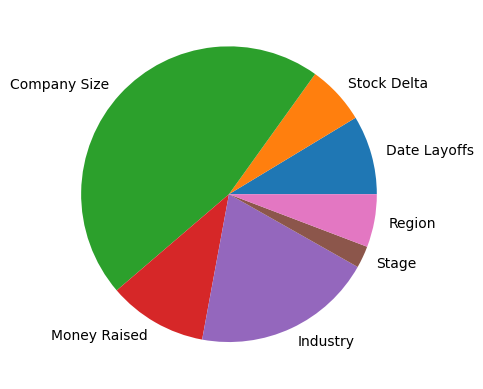

In [38]:
plt.pie(importances, labels=categories)

Figure above shows importance of each feature in prediction

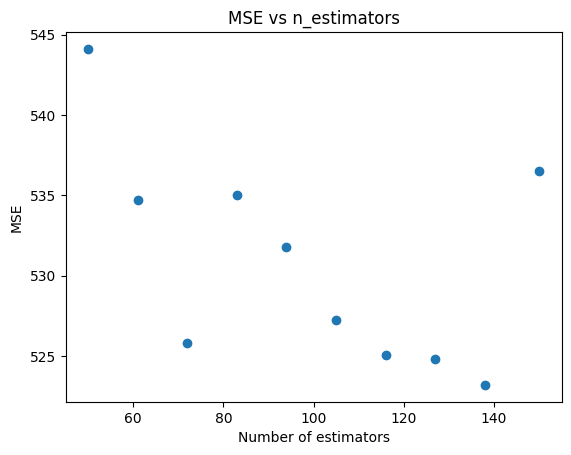

In [39]:
mses_vs_estimators = [x[max_depth.index(bestDepth)][min_samples_split.index(bestSamples)] for x in mses]
plt.scatter(n_estimators, mses_vs_estimators)
plt.xlabel("Number of estimators")
plt.ylabel("MSE")
plt.title("MSE vs n_estimators")
plt.show()

For constant depth and min number of samples, we can plot the MSE vs the number of estimators. Here, we set depth and min number of samples as the best values found by Grid Search. Clearly, we can see that there is an optimal number of estimators at `n_estimators = 94` where the MSE is minimized.

# **LSTM Model**

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_lstm_model():
    '''
    Build a more complex LSTM model with stacked LSTM layers, dropout, and additional dense layers for better representation.
    '''
    model = Sequential([
        # First LSTM Layer with 100 units, returns sequences for stacking
        LSTM(100, activation='relu', input_shape=(None, 61), return_sequences=True),
        Dropout(0.3),  # Add dropout to prevent overfitting

        # Second LSTM Layer with 50 units, returns sequences for another layer
        LSTM(50, activation='relu', return_sequences=True),
        Dropout(0.3),

        # Third LSTM Layer with 25 units, doesn't return sequences (last LSTM layer)
        LSTM(25, activation='relu', return_sequences=False),
        Dropout(0.3),

        # First Dense Layer with 50 units
        Dense(50, activation='relu'),
        BatchNormalization(),  # Optional batch normalization for stable training

        # Second Dense Layer with 25 units
        Dense(25, activation='relu'),

        # Output Dense Layer: a single output neuron without any activation (linear)
        Dense(1, activation='linear'),
    ])

    # Compile the model with the Adam optimizer and the learning rate found in the hyperparameter tuning
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mean_squared_error', metrics=['mse'], run_eagerly=True)

    return model

# Example usage: create and compile the LSTM model
lstm_model = build_lstm_model()
lstm_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, None, 100)           │          64,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 50)            │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 50)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 25)                  │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 50)                  │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 105,401 (411.72 KB)

 Trainable params: 105,301 (411.33 KB)

 Non-trainable params: 100 (400.00 B)

In [41]:
from sklearn.preprocessing import StandardScaler

n = len(X)  # Total number of data points

# Split sizes
train_size = int(0.8 * n)  # 80% for training
val_size = int(0.05 * n)   # 5% for validation
test_size = n - train_size - val_size  # Remaining 15% for testing

# Chronologically splitting the data
X_train, y_train = X[:train_size], Y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], Y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], Y[train_size + val_size:]

# Converting to numpy arrays if needed
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_val_np = scaler.transform(X_val_np)
X_test_np = scaler.transform(X_test_np)

X_train_lstm = np.expand_dims(X_train_np, axis=1)
X_val_lstm = np.expand_dims(X_val_np, axis=1)
X_test_lstm = np.expand_dims(X_test_np, axis=1)

# Check the shape of the data
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_val_lstm shape:", X_val_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)

X_train_lstm shape: (802, 1, 61)
X_val_lstm shape: (50, 1, 61)
X_test_lstm shape: (151, 1, 61)


In [45]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Build the LSTM model
lstm_model = build_lstm_model()

def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.1
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Train the LSTM model
history = lstm_model.fit(
    X_train_lstm, y_train_np,
    validation_data=(X_val_lstm, y_val_np),
    epochs=30,
    batch_size=16,
    callbacks=[lr_scheduler]
    )

# Evaluate the model on the test set
test_mse = lstm_model.evaluate(X_test_lstm, y_test_np)
print(f"Test MSE: {test_mse}")

# Optionally, make predictions on the test set
y_pred = lstm_model.predict(X_test_lstm)
y_pred_squeezed = np.squeeze(y_pred)
# You can inspect the predictions versus actual values
print("Predictions:", y_pred_squeezed)
print("Actual values:", y_test_np)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - loss: 843.9603 - mse: 843.9603 - val_loss: 336.6591 - val_mse: 336.6591 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - loss: 757.8629 - mse: 757.8629 - val_loss: 315.8224 - val_mse: 315.8224 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - loss: 522.6083 - mse: 522.6083 - val_loss: 271.5943 - val_mse: 271.5943 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - loss: 393.2434 - mse: 393.2434 - val_loss: 211.3822 - val_mse: 211.3822 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513